In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tqdm 
!pip install wandb -qqq
!pip install timm
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install einops
clear_output()

In [4]:
!pip install -U albumentations

In [5]:
!git clone https://github.com/Bjarten/early-stopping-pytorch

fatal: destination path 'early-stopping-pytorch' already exists and is not an empty directory.


In [6]:
import sys
sys.path.append('/content/early-stopping-pytorch')

In [7]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download schulta/petfinder-pawpularity-score-clean
!unzip /content/petfinder-pawpularity-score-clean.zip -d /data/
clear_output()

In [8]:
import os
import gc
import pandas as pd
import numpy as np
import wandb
import cv2
import timm
from timm.models import load_checkpoint
from tqdm.notebook import trange, tqdm

from einops import rearrange, reduce, repeat
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import AdamW, Adam
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorchtools import EarlyStopping
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import ShuffleSplit
from datetime import datetime

In [9]:
Config = {
    'CSV_PATH': "/data/train.csv",
    'IMG_PATH': "/data/train",
    'TEST_PATH': '/data/test',
    'N_SPLITS': 5,
    'TRAIN_BS': 16,
    'VALID_BS': 16,
    'N_EPOCHS': 10,
    'NUM_WORKERS': 4,
    'LR': 1e-5,
    'ARCH': 'vit_large_patch16_224',
    'OPTIM': "AdamW",
    'SCH_STEP': 4,
    'GAMMA': 0.1,
    'SCHEDULER': 'CosineWarm',
    "T_0": 20,
    "η_min": 1e-6,
    'PATIENCE': 3,
    'LOSS': "RMSE",
    'IMG_SIZE': 224,
    'DEVICE': "cuda",
    'infra': "Colab",
    'competition': 'pawpularity',
    '_wandb_kernel': 'tanaym',
    "wandb": True,
}

In [10]:
class PawsDataset(Dataset):
    def __init__(self, df, config=Config, augments=None, target_transform=None, is_test=False,is_val=False):
        if type(df) == pd.core.frame.DataFrame:
            self.df = df
        else:
            self.df = pd.read_csv(df)
        self.config = config
        self.transform = augments
        self.target_transform = target_transform
        self.is_test = is_test
        self.is_val = is_val
        
        self.img_paths = self._get_img_paths(self.df, self.config)
        self.meta_feats = self._get_meta_feats(self.df, self.is_test)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.img_paths[idx]
        #image = read_image(img_name)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = rearrange(image, 'c x y -> x y c')
        label = self.df.iloc[idx, -1]
        label = np.array([label])
        if self.transform:
            image = self.transform(image=image)['image']
        sample = {'image': image, 'label': label}
        return sample
 
    def __len__(self):
        return len(self.df)

    def _get_img_paths(self, df, config):
        """
        Returns the image paths in a list
        """
        if self.is_val:
            imgs = df['Id'].apply(lambda x: os.path.join(config['TEST_PATH'], x + ".jpg")).tolist()
        else:
            imgs = df['Id'].apply(lambda x: os.path.join(config['IMG_PATH'], x + ".jpg")).tolist()
        return imgs
    
    def _get_meta_feats(self, df, is_test):
        """
        Returns the meta features in a df
        """
        if self.is_test or self.is_val:
            meta = self.df.drop(['Id'], axis=1)
            return meta
        else:
            meta = self.df.drop(['Id', 'Pawpularity'], axis=1)
            return meta

In [11]:
class GetDate():
    def __init__(self):
        self.currentMinute = datetime.now().minute
        self.currentHour = datetime.now().hour
        self.currentDay = datetime.now().day
        self.currentMonth = datetime.now().month
        self.currentYear = datetime.now().year

In [12]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [13]:
def plot_loss_val(training_losses,valid_losses):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(training_losses,label="train")
    plt.plot(valid_losses,label="val")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [14]:
paws_dataset = PawsDataset(df=Config['CSV_PATH'],)
paws_dataset.df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9880,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9881,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9882,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9883,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [15]:
def plot_image(image):
    """Show image with landmarks"""
    plt.imshow(image)

    plt.pause(0.001)  # pause a bit so that plots are updated


  0%|          | 0/5 [00:00<?, ?it/s]

0 (720, 405, 3) Pawpularity:[63]


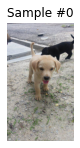

1 (774, 1032, 3) Pawpularity:[42]


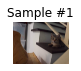

2 (960, 720, 3) Pawpularity:[28]


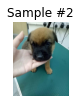

3 (720, 405, 3) Pawpularity:[15]


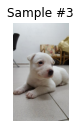

4 (960, 540, 3) Pawpularity:[72]


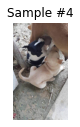

In [16]:
fig = plt.figure()

for i in tqdm(range(5)):
    sample = paws_dataset[i]
    image = sample['image'] 
    print(f"{i} {image.shape} Pawpularity:{sample['label']}")

    if image.shape[0] == 3:
        image = rearrange(image,'c x y -> x y c')
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    plot_image(image)


In [17]:
train_aug = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.Flip(p=0.5),
        A.GaussNoise(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.1),
        A.RandomBrightnessContrast(p=0.4),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_aug = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.transforms.ToTensorV2(),
    ]
)

In [18]:
X = paws_dataset.df.iloc[:,:-1]
y = paws_dataset.df['Pawpularity']
rs = ShuffleSplit(n_splits=1, test_size=.2, random_state=42)
rs.get_n_splits(X)

print(rs)

for train_index, test_index in rs.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)

ShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=None)
TRAIN: [6740 5123 8601 ... 5390  860 7270] TEST: [4170 5809 3023 ...  473 6537 5477]


In [19]:
training_data = PawsDataset(df=paws_dataset.df.iloc[train_index],config=Config,augments=train_aug)

test_data = PawsDataset(df=paws_dataset.df.iloc[test_index],config=Config,augments=test_aug,is_test=True)

In [20]:
trainloader = DataLoader(training_data, batch_size=Config['TRAIN_BS'], shuffle=True)

testloader = DataLoader(test_data,batch_size=Config['TRAIN_BS'],shuffle=True)

In [21]:
model_name = Config['ARCH']
model = timm.create_model(model_name, pretrained=True)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  

In [22]:
model.head = nn.Linear(model.head.in_features,1)

In [ ]:
model

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
model.to(device)

clear_output()

In [25]:
def train(epoch):
    running_loss = 0.0
    loss_values = []
    model.train()
    with tqdm(trainloader, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = data['image'], data['label']
            labels = labels.to(torch.float32)
            inputs = inputs.to(device) 
            labels = labels.to(device)
            # zero the parameter gradients
            scheduler2.step(epoch+i/len(tepoch))
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion2(outputs, labels)
            #rmseloss = criterion2(outputs,labels)
            loss.backward()
            optimizer.step()
            # print statistics 
    
            running_loss += loss.item()
            loss_values.append(loss.item())
            if i % 64 == 0 and i>0:    # every 64 mini-batches
                train_loss = running_loss/i
                print(i)
                print(f'Training loss: {train_loss}')
        train_loss = sum(loss_values) /len(tepoch)
        
        gc.collect()
        torch.cuda.empty_cache()
        return train_loss

In [26]:
def test(epoch):
    losslis=[]
    test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    with torch.no_grad():
        for data in tqdm(testloader):
            inputs, labels = data['image'], data['label']
            # calculate outputs by running images through the network
            labels = labels.to(torch.float32)
            inputs = inputs.to(device) 
            labels = labels.to(device)
            outputs = model(inputs)
            # print(outputs)
            # print(labels)
            loss = criterion2(outputs,labels)

            test_loss += loss.item()
            losslis.append(loss.item())
            #writer.add_scalar('Test/Loss', test_loss, epoch)  
        test_loss = test_loss/len(testloader)
        print(f'Validation loss: {test_loss}')
    gc.collect()
    torch.cuda.empty_cache()
    return test_loss

In [27]:
criterion1 = nn.BCEWithLogitsLoss()
criterion2 = RMSELoss()
optimizer = AdamW(model.parameters(), lr=Config['LR'] )

In [28]:
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=Config['SCH_STEP'],
                gamma=Config['GAMMA']) 
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=Config['T_0'],
                eta_min=Config['η_min'])

In [29]:
scheduler_name = f"{Config['SCHEDULER']}_{Config['SCH_STEP']}_{Config['GAMMA']}"
early_stopping = EarlyStopping(patience=Config['PATIENCE'], verbose=True)

In [30]:
if Config['wandb']:
  wandb.init(project="pawpularity_kaggle_final", entity="edgarlcs",config=Config,name=f'{model_name}_{scheduler_name}_epoch{Config["N_EPOCHS"]}_{Config["TRAIN_BS"]}')
  wandb.watch(model)

wandb: Currently logged in as: edgarlcs (use `wandb login --relogin` to force relogin)


In [31]:
epochs = Config['N_EPOCHS']
training_losses = []
valid_losses = []

for epoch in tqdm(range(1,epochs+1)):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
    #scheduler2.step()
    early_stopping(test_loss, model)
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    if Config['wandb']:
      wandb.log({
        "Epoch": epoch,
        "Train Loss": train_loss,
        "Valid Loss": test_loss})
    else:
      training_losses.append(train_loss)
      valid_losses.append(test_loss)
print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?batch/s]

64
Training loss: 23.775204464793205
128
Training loss: 21.519349448382854
192
Training loss: 20.690198649962742
256
Training loss: 20.20080081000924
320
Training loss: 19.91635960638523
384
Training loss: 19.82130380968253
448
Training loss: 19.69954062998295


  0%|          | 0/124 [00:00<?, ?it/s]

Validation loss: 19.01289475348688
Validation loss decreased (inf --> 19.012895).  Saving model ...


  0%|          | 0/495 [00:00<?, ?batch/s]

64
Training loss: 19.519830614328384
128
Training loss: 18.27313081175089
192
Training loss: 18.216439756254356
256
Training loss: 18.32769967801869
320
Training loss: 18.43473815321922
384
Training loss: 18.29457504550616
448
Training loss: 18.211143461721285


  0%|          | 0/124 [00:00<?, ?it/s]

Validation loss: 19.465734166483724
EarlyStopping counter: 1 out of 3


  0%|          | 0/495 [00:00<?, ?batch/s]

64
Training loss: 17.64696830511093
128
Training loss: 17.309968940913677
192
Training loss: 17.557084689537685
256
Training loss: 17.452031979337335
320
Training loss: 17.523846827447414
384
Training loss: 17.424702662974596
448
Training loss: 17.397435925900936


  0%|          | 0/124 [00:00<?, ?it/s]

Validation loss: 19.113293978475756
EarlyStopping counter: 2 out of 3


  0%|          | 0/495 [00:00<?, ?batch/s]

64
Training loss: 17.002250522375107
128
Training loss: 16.80110201239586
192
Training loss: 16.73009569197893
256
Training loss: 16.777361745014787
320
Training loss: 16.596191285550596
384
Training loss: 16.578625425696373
448
Training loss: 16.509478709527425


  0%|          | 0/124 [00:00<?, ?it/s]

Validation loss: 18.14323628333307
Validation loss decreased (19.012895 --> 18.143236).  Saving model ...


  0%|          | 0/495 [00:00<?, ?batch/s]

64
Training loss: 15.024598084390163
128
Training loss: 15.832190919667482
192
Training loss: 15.854659117758274
256
Training loss: 15.776078766211867
320
Training loss: 15.726467078924179
384
Training loss: 15.707156422237555
448
Training loss: 15.65132968553475


  0%|          | 0/124 [00:00<?, ?it/s]

Validation loss: 18.3118238026096
EarlyStopping counter: 1 out of 3


  0%|          | 0/495 [00:00<?, ?batch/s]

64
Training loss: 14.375644341111183
128
Training loss: 14.452793627977371
192
Training loss: 14.407437364260355
256
Training loss: 14.346018139272928
320
Training loss: 14.404621605575084
384
Training loss: 14.42170549184084
448
Training loss: 14.3658385936703


  0%|          | 0/124 [00:00<?, ?it/s]

Validation loss: 18.253081998517438
EarlyStopping counter: 2 out of 3


  0%|          | 0/495 [00:00<?, ?batch/s]

64
Training loss: 13.830086305737495
128
Training loss: 13.915023893117905
192
Training loss: 13.910071422656378
256
Training loss: 13.868914356455207
320
Training loss: 13.859402677416801
384
Training loss: 13.817761159191528
448
Training loss: 13.76868683631931


  0%|          | 0/124 [00:00<?, ?it/s]

Validation loss: 18.230878903019814
EarlyStopping counter: 3 out of 3
Early stopping
Finished Training


In [32]:
if Config['wandb'] == False:
  plot_loss_val(training_losses,valid_losses)

In [33]:
now = GetDate()